# Mapping human lymph node cell types to 10X Visium - estimating reference expression signatures

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YosefLab/scvi-tools/blob/37af9b2a43667c1bfb64d55f51b4a245f5738be6/scvi/external/cell2location/tutorial/cell2location_analysis_2_estimating_signatures.ipynb)

Cell2location maps cell types by integrating single cell/nucleus and spatial transcriptomics data. This is achieved by estimating which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, taking technical effects into account (platform/technology effect, contaminating RNA, unexplained variance).

Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f={1, .., F}$, can be estimated from sc/snRNA-seq data using 2 provided methods (see below). Cell2location needs untransformed unnormalised spatial mRNA counts as input. You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see paper methods for more guidance).

We provide 2 methods for estimating reference expression signatures of cell types from scRNA-seq data:

1) a statistical method based on Negative Binomial regression. We generally recommend using NB regression, which allows to robustly combine data across technologies and batches, which results in improved spatial mapping accuracy. This notebook shows use a dataset composed on multiple batches and technologies to estimate that. 

2) hard-coded computation of per-cluster average mRNA counts for individual genes (`scvi.external.cell2location.compute_cluster_averages`). When the batch effects are small, this faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.


### Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load refence cell type expression signatures](#Loading_signatures)
* [Run scvi-cell2location](#cell2location)
* [Leiden clustering of cell abundance](#region_clustering)




### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "pyro-cell2location"
user = "vitkl"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
import sys
if not IN_COLAB:
    sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output.

In [2]:
results_folder = './results/lymph_nodes_analysis/'
scvi_run_name = f'{results_folder}/non_amortised/signatures_lr0002_Adam'

adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Estimation of reference cell type expression signatures <a class="anchor" id="Loading_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [3]:
import os
if not os.path.exists('./data/sc.h5ad'):
    !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad 

In [4]:
# read data
adata_snrna_raw = sc.read(f'./data/sc.h5ad')

# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var.index 
adata_snrna_raw.var.index = adata_snrna_raw.var['GeneID-2'].copy()
adata_snrna_raw.var_names = adata_snrna_raw.var['GeneID-2'].copy()
adata_snrna_raw.var.index.name = None
adata_snrna_raw.raw.var['SYMBOL'] = adata_snrna_raw.raw.var.index
adata_snrna_raw.raw.var.index = adata_snrna_raw.raw.var['GeneID-2'].copy()
adata_snrna_raw.raw.var.index.name = None

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_snrna_raw, 
                        # 10X reaction / sample / batch
                        batch_key='Sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )
scvi.data.view_anndata_setup(adata_snrna_raw)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["Subset"]                                               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/ca

INFO     Successfully registered anndata object containing 73260 cells, 10237 vars, 23       
         batches, 34 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/ca

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [41:38<00:00,  9.99s/it, v_num=1, elbo_train=2.88e+8]


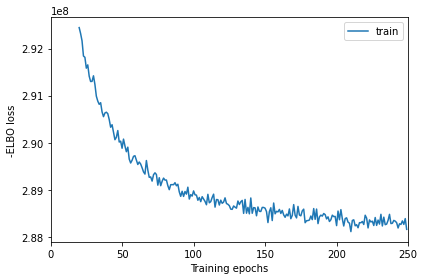

In [5]:
# create and train the regression model
import pyro
from scvi.external.cell2location import RegressionModel
mod = RegressionModel(
    adata_snrna_raw,
    # use amortised inference using a neural network for cell-specific normalisation
    #amortised=True
) 

mod.train(max_epochs=250, 
          batch_size=2500, 
          # Use all data for training (validation not implemented yet)
          train_size=1, 
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [6]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_v0_ref", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}_v0_ref/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:31<00:00, 31.32it/s]


'./results/lymph_nodes_analysis//non_amortised/signatures_lr0002_Adam_v0_ref/sc.h5ad'

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

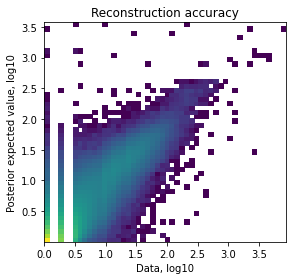

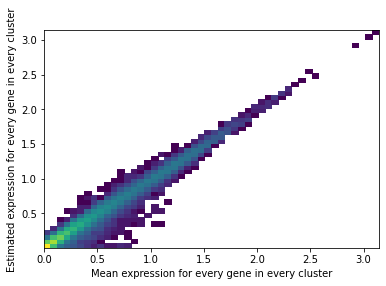

In [7]:
mod.plot_QC()

In [5]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_ref", adata_snrna_raw)
adata_file = f"{scvi_run_name}_ref/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

In [6]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN
ENSG00000188976   0.286211  0.183432  0.229675    0.269630  0.125889
ENSG00000188290   0.001551  0.000477  0.000556    0.041313  0.034876
ENSG00000187608   0.256078  0.167128  0.208980    0.415600  3.244958
ENSG00000186891   0.011823  0.000615  0.041789    0.052284  0.008038
ENSG00000186827   0.004274  0.000387  0.004441    0.023630  0.009090

## Train scvi-cell2location <a class="anchor" id="scvi-cell2location"></a>

In [7]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

In [8]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4035 cells, 10217 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:28:42<00:00,  3.36it/s, v_num=1, elbo_train=4.54e+7]  


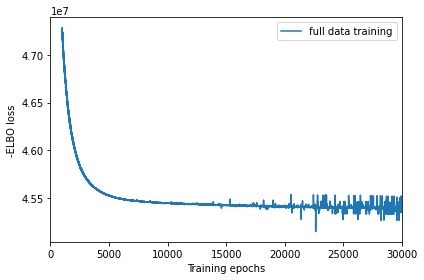

In [9]:
# create and train the model
import pyro
mod = scvi.external.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
    N_cells_per_location=30) 

mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [10]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': 2020, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_v0ref_30kiter_c2l_expected", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.Cell2location.load(f"{scvi_run_name}_c2l", adata_vis)

# compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples[f"post_sample_q05"], mod.adata
)

# add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{scvi_run_name}_v0ref_30kiter_c2l_expected/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:22<00:00, 44.22it/s]


... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


'./results/lymph_nodes_analysis//non_amortised/signatures_lr0002_Adam_v0ref_30kiter_c2l_expected/sp.h5ad'

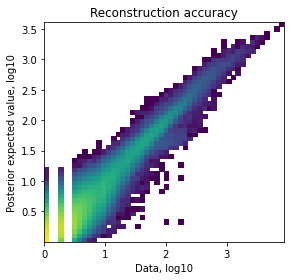

In [11]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

### Plot cell abundance in spatial coordinates

In [12]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


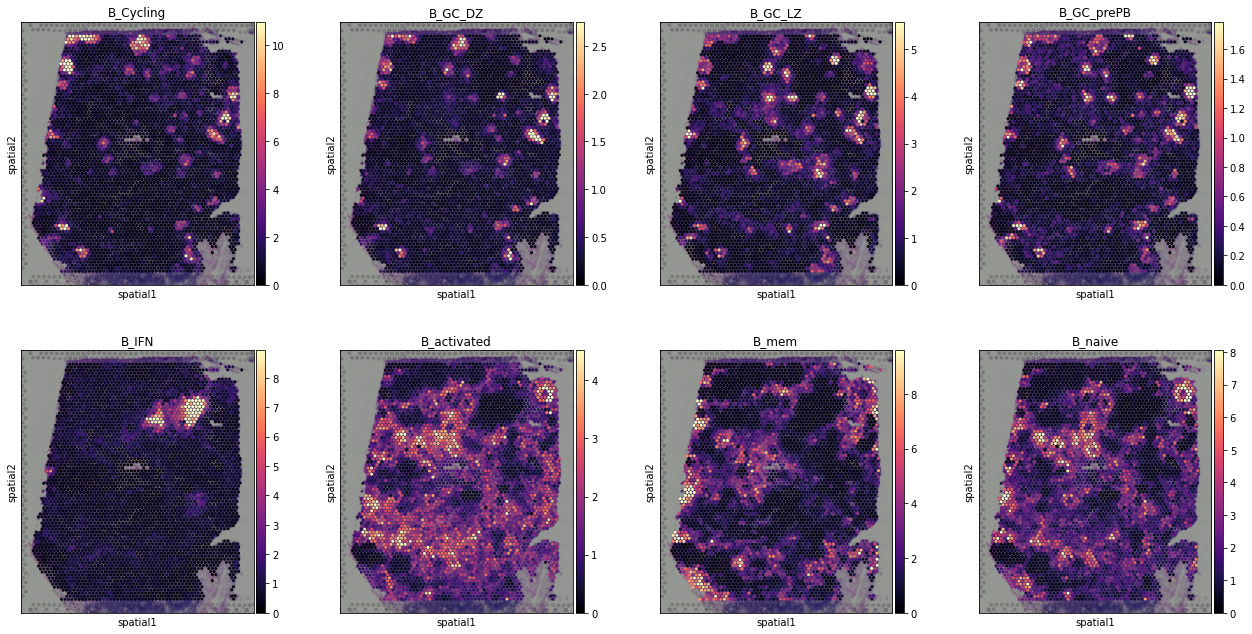

In [13]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
    
    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'][0:8], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


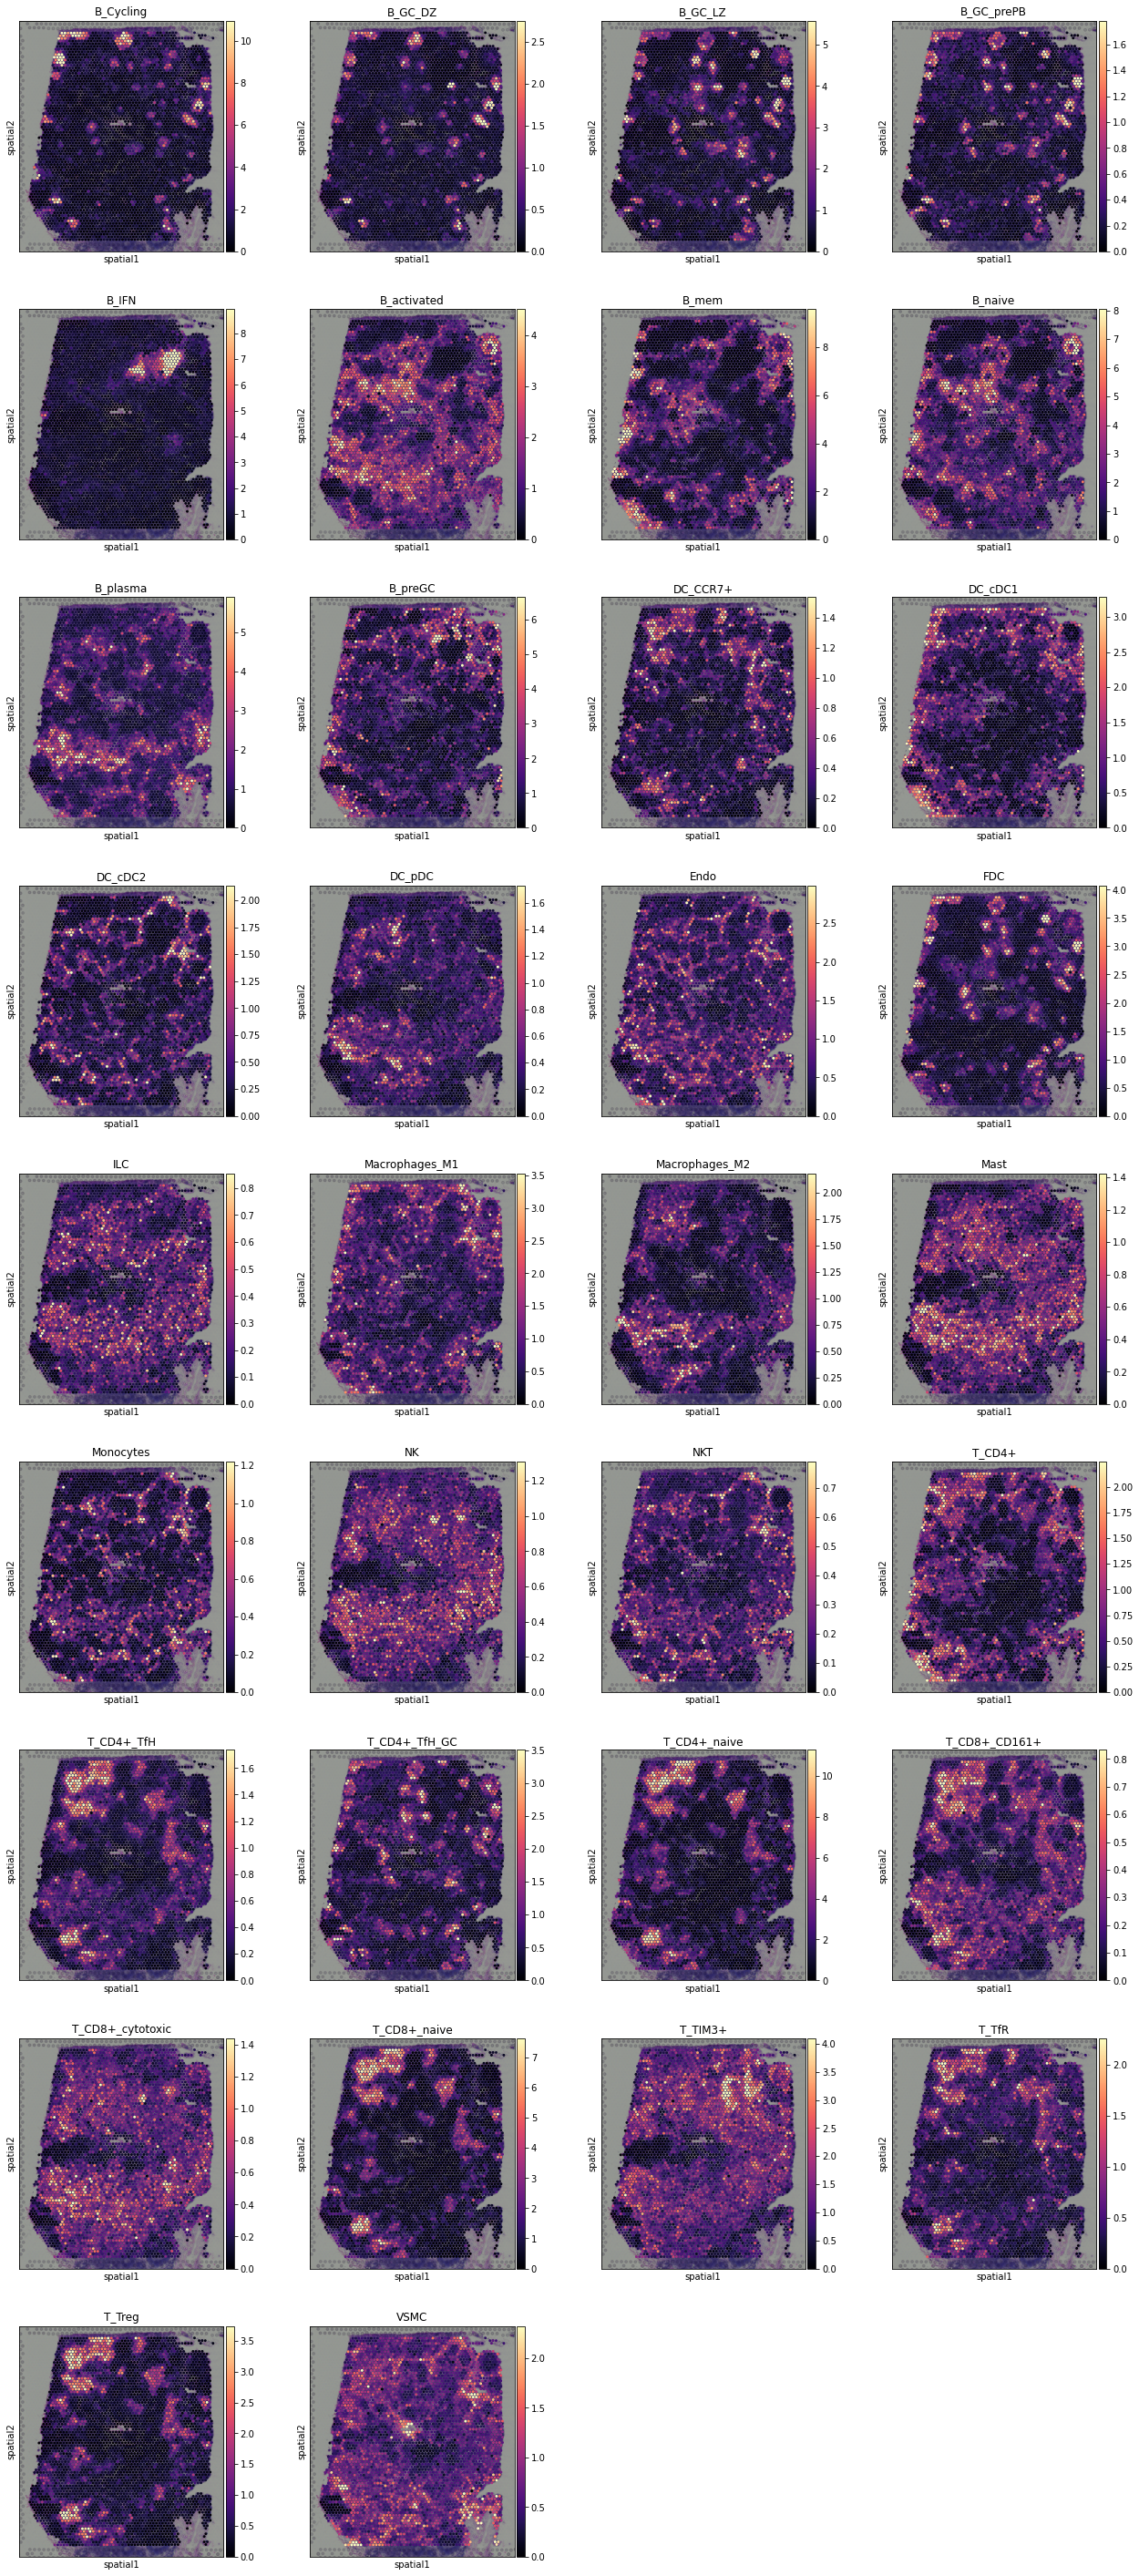

In [14]:
# plot in spatial coordinates for all cell types
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
    
    sc.pl.spatial(slide, cmap='magma',
                  color=adata_vis.uns['mod']['factor_names'], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


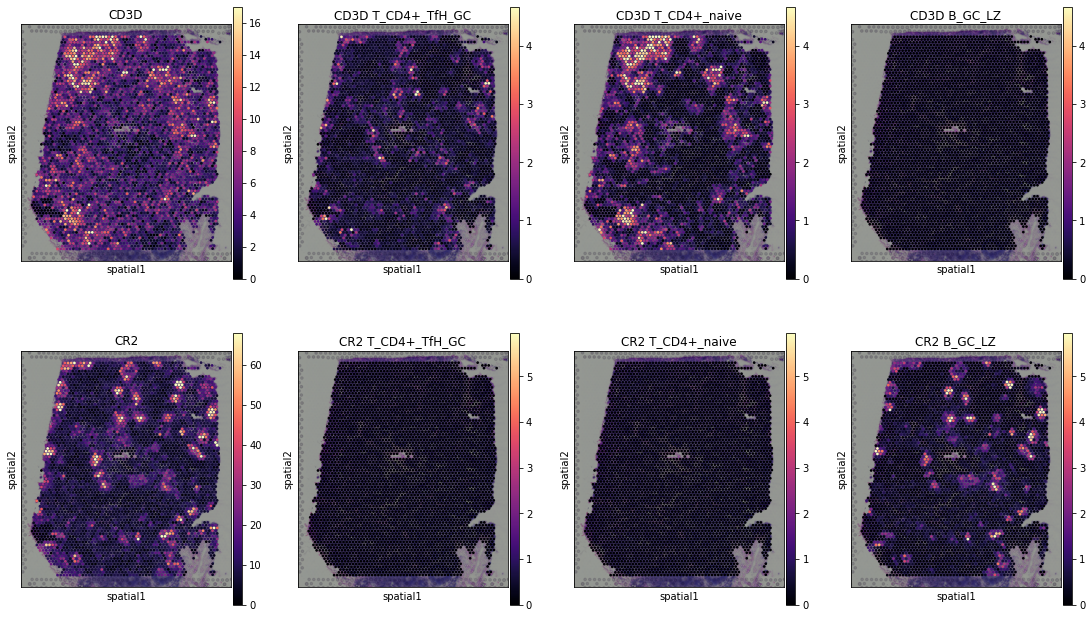

In [56]:
# Look at cell type specific expression in spatial coordinates, 
# Here we highlight CD3D, pan T-cell marker expressed by 
# 2 subtypes of T cells in distinct locations but not expressed by co-located B cells
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
    
    fig, axs = plt.subplots(nrows=len(genes), ncols=len(ctypes)+1, 
                           figsize=(4.5 * (len(ctypes)+1) + 1, 5 * len(genes) + 1))
    axs = axs.reshape((len(genes), len(ctypes)+1))
    
    # plots of every gene
    for j in range(len(genes)):
        
        # limit color scale at 99.2% quantile of gene expression (computed across cell types)
        quantile_across_ct = np.array([
            np.quantile(slide.layers[n][:, slide.var['SYMBOL'] == genes[j]].toarray(), 0.992) 
            for n in adata_vis.uns['mod']['factor_names']
        ])
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        sc.pl.spatial(slide, cmap='magma',
                          color=genes[j], 
                          #layer=ctypes[i],
                          gene_symbols='SYMBOL',
                          ncols=4, size=1.3, 
                          img_key='hires',
                          # limit color scale at 99.2% quantile of gene expression
                          vmin=0, vmax='p99.2',
                          ax=axs[j, 0], show=False
                         )
        
        # plots of every cell type
        for i in range(len(ctypes)):
            sc.pl.spatial(slide, cmap='magma',
                          color=genes[j], 
                          layer=ctypes[i],
                          gene_symbols='SYMBOL',
                          ncols=4, size=1.3, 
                          img_key='hires',
                          # limit color scale at 99.2% quantile of gene expression
                          vmin=0, vmax=quantile_across_ct,
                          ax=axs[j, i+1], show=False
                         )
            axs[j, i+1].set_title(f'{genes[j]} {ctypes[i]}')

## Perform clustering of cell abudance estimates to identify tissue regions <a class="anchor" id="region_clustering"></a>

We find regions by clustering locations/spots (Leiden) based on estimated cell abundance of each cell type. Results are saved in `adata_vis.obs['region_cluster']`.

In [15]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

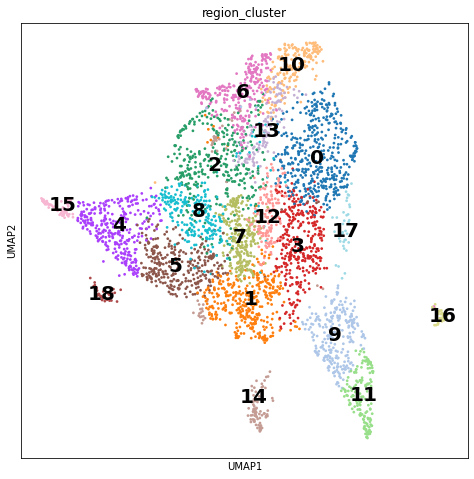

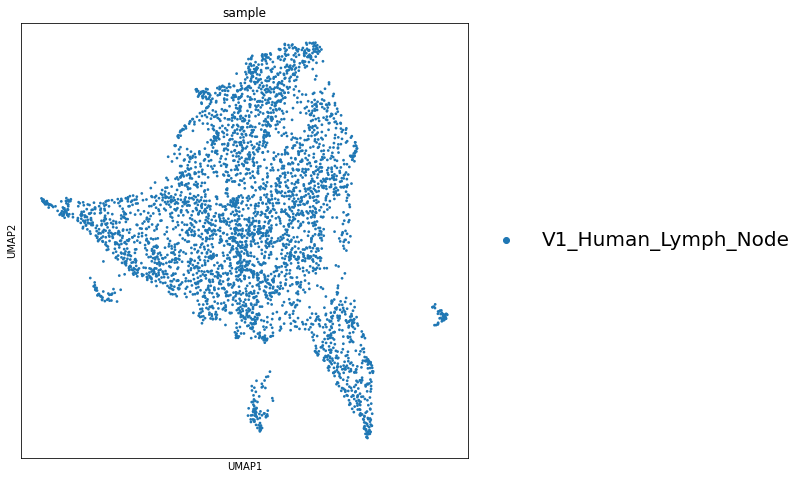

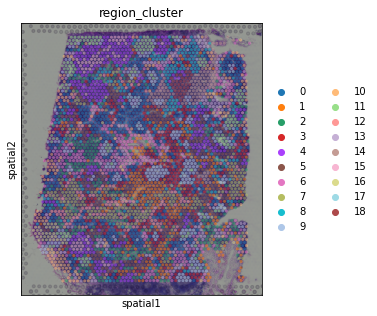

In [16]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

### Advanced use examples

In [17]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

Sampling global variables, sample: 100%|██████████| 999/999 [00:21<00:00, 46.92it/s]


(1000, 4035, 34)

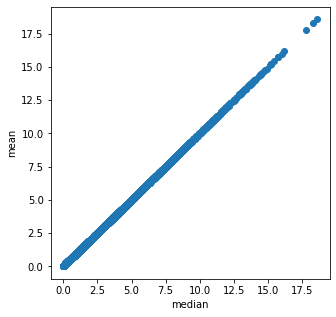

In [18]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

Modules and their versions used for this analysis

In [19]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.